In [2]:
BATCH_SIZE = 32
INPUT_SHAPE = (25, 16, 1)
DATASET_PATH = "output_frames"
DATASET_ZIP = "dataset.zip"

## Foundation

Include required libraries and tools under this section and adjust settings.

**TODO:**
- [ ] Explore the usage of garbage collections.

In [3]:
# Import required libraries.
import  tensorflow as tf

from    keras.models import Sequential
from    keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from    keras.utils import to_categorical

# Helper libraries.
import  pandas as pd
import  numpy as np
from    sklearn.model_selection import train_test_split
from    sklearn.preprocessing import LabelEncoder
import  librosa

# Libraries for plotting.
import  matplotlib.pyplot as plt

# Other
import sys
import os
import zipfile

In [4]:
# Test for GPU and determine what GPU we have.
# Modified by student to remove warningen caused on local machine.
IN_COLAB = 'google.colab' in sys.modules

gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    compute_capability=details.get('compute_capability')
    print("Compute capability:",compute_capability)
    if compute_capability[0]>6:
        print("Turn on mixed_float16")
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("No GPU detected.")

Compute capability: (7, 5)
Turn on mixed_float16


In [5]:
# Modify GPU memory allocator to try to prevent full GPU memory.
# This can in some cases be counter productive!
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [6]:
# Install Keras Tuner via PIP (if in colab).
if IN_COLAB:
    os.system('pip install keras_tuner')

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

Keras Tuner version: 1.4.7


## Import Dataset

If you're using Google Colab, the dataset has to be imported from Google Drive (or uploaded as a ZIP-file). This required giving permission to Google Colab! Otherwise, it will check if the dataset folder exists, if not, terminates the execution.

**TODO:**
- [ ] Add support for uploaded dataset.zip files.

In [7]:
# Function to load a ZIP file from Google Drive.
def load_zip_file(zip_path):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Extract to a specific directory
            zip_ref.extractall(DATASET_PATH)
            print(f"ZIP file '{zip_path}' loaded successfully.")
    except FileNotFoundError:
        print(f"Error: ZIP file not found at '{zip_path}'.")
    except zipfile.BadZipFile:
        print(f"Error: Invalid ZIP file at '{zip_path}'.")

# If in Colab, load the ZIP file from Google Drive.
if IN_COLAB:
    print("Loading and extracting dataset ZIP-file form Drive.")
    if (not os.path.exists(DATASET_PATH)):
        load_zip_file("drive/MyDrive/Studies/KTH/Courses/II143X/Model Creation/Data/output_frames.zip")
        
# Otherwise, check of files exist.
else:
    print("No Colab detected, using pre-existing files.")
    if (not os.path.exists(DATASET_PATH)):
        print("Error: Dataset not found.")
        sys.exit()

No Colab detected, using pre-existing files.
Error: Dataset not found.


SystemExit: 

/home/fridh/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#data2 = np.loadtxt("output_frames.csv", delimiter=",")


In [ ]:
#data = np.genfromtxt("output_frames.csv", delimiter=",", encoding='utf-8')


In [8]:
df = pd.read_csv('output_frames.csv', header=None)              # No header in your format
dataset = df.iloc[:, :-1].to_numpy(dtype=np.float16)            # All but last column as float16
labels_set = df.iloc[:, -1].to_numpy(dtype=str)                 # Last column as string

In [9]:
# (104707, 25, 16, 1)

In [10]:
dataset = dataset.reshape(dataset.shape[0], 25, 16, 1)

print(dataset.shape)
print(labels_set.shape)

(104707, 25, 16, 1)
(104707,)


In [11]:
print(labels_set[0:10])

['Background_noise' 'Background_noise' 'Background_noise'
 'Background_noise' 'Background_noise' 'Background_noise'
 'Background_noise' 'Background_noise' 'Background_noise'
 'Background_noise']


# Preparing dataset

To prepare the data, we first read through each frame file from the dataset and stores the path alongside it's label in array **dataset** and also addes the label, if not already existing, to **labels**.

We then prepare a function to reads TXT file data and convert it to NP array, followed by a function used for plotting int MFCC for debugging.

In [12]:
# Plot MFCC
def plot_mfcc(mfccs):
    # Flatten the data
    mfccs = mfccs.reshape((25, 16))
    # Plot the MFCC
    print(f"MFCC shape: {mfccs.shape}")
    mfccs = mfccs
    librosa.display.specshow(mfccs, x_axis='time', sr=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficient')
    plt.show()

MFCC shape: (25, 16)


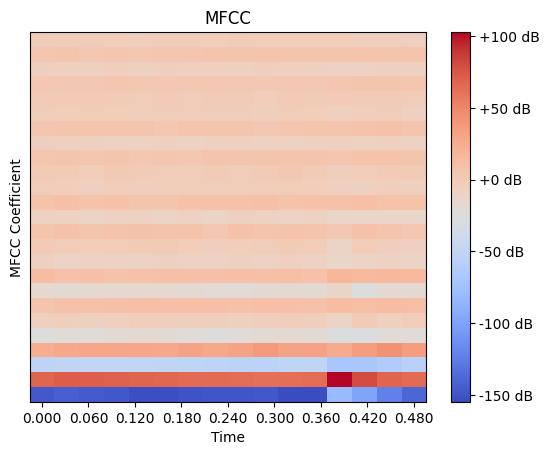

In [13]:
# Pass exmaple frame data to plot_mfcc function.
plot_mfcc(dataset[0])

### Splitting Dataset

When data have been explored, we split the data into three groups: training, validating, and testing. Where training and validating will be used for the training process, and testing for the final testing.

In [14]:
# Split the dataset into training and testing sets.
x_train, x_test, y_train, y_test = train_test_split(dataset, labels_set, test_size=0.2, random_state=42)

# Print the lengths of the training, validation, and testing sets.
print(f"Training set length: {len(x_train)}")
print(f"Testing set length: {len(x_test)}")

Training set length: 83765
Testing set length: 20942


In [15]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights.
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dist_class_weight = dict(enumerate(class_weight))

In [16]:
print(dist_class_weight)

{0: np.float64(1.9336334256694367), 1: np.float64(0.9208992963940194), 2: np.float64(0.9252938317426652), 3: np.float64(0.9089675977168652), 4: np.float64(0.90000214887399), 5: np.float64(0.9050196637711223)}


In [17]:
# Hot end code the labels.
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.fit_transform(y_test))

In [18]:
print(f"Classes: {np.unique(labels_set)}")

Classes: ['Background_noise' 'Bicycle' 'Bus' 'Car' 'Motorcycle' 'Truck']


# Helper Functions

There are two helper functions: printHistory (used for plotting graphs to udnerstand over- and udner-fitting), as well as fitModel (used for fitting model one or multiple times).

In [19]:
# Print training history
# Function used for printing two plots, one for accuracy and one for loss.
# To be used with the history object from the fit method
def printHistory(history):
  # Collect the number of epochs run based on the amount of loss value under history.
  epochs = len(history.history['loss']) 

  epochrange = range(1, epochs + 1)
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc')
  plt.plot(epochrange, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss')
  plt.plot(epochrange, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [20]:
# Fit model function used for convinience when fitting the model multiple times
def fitModel(model, x_train, y_train, epochs, doPrintHistory, class_weight, verbose, batch_size):
    history = model.fit(x=x_train, y=y_train, validation_split=0.25, epochs=epochs, verbose=verbose, class_weight=class_weight, batch_size=batch_size)
    # Print history
    if doPrintHistory: printHistory(history)

# Construct Sequantial Model

...

In [21]:
# Creation of the sequential model
sequential_model = Sequential([
    Conv2D(filters = 64, kernel_size = (3,3), activation = "relu", padding = 'same', input_shape = INPUT_SHAPE),
    Conv2D(filters = 64, kernel_size = (2,2), activation = "relu", padding = 'same'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.4),
    Conv2D(filters = 128, kernel_size = (3,3), activation = "relu", padding = 'same'),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation = "relu"),
    Dense(64, activation = "relu"),
    Dropout(0.6),
    Dense(units = len(np.unique(labels_set)), activation = "softmax")
])


/home/fridh/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1741970897.991216   21567 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1741970897.993064   21567 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3956 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


In [22]:
# Print a summary of the model architecture
sequential_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 16, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 16, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 8, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 492,934 (1.88 MB)

 Trainable params: 492,934 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile the model.
sequential_model.compile(
    optimizer = "Adam",
    loss = "categorical_crossentropy",
    metrics = ['categorical_accuracy']
)

Epoch 1/16


2025-03-14 17:48:25.911441: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100516800 exceeds 10% of free system memory.
2025-03-14 17:48:26.009938: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100516800 exceeds 10% of free system memory.
I0000 00:00:1741970907.898189   27745 service.cc:148] XLA service 0x78eaa000e070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741970907.898501   27745 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-03-14 17:48:27.980078: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741970908.341361   27745 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-14 17:48:29.495234: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potential

  38/1964 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - categorical_accuracy: 0.1555 - loss: 5.8908 

I0000 00:00:1741970912.791047   27745 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1952/1964 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.2124 - loss: 2.0481

2025-03-14 17:48:41.041711: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=3,k6=3,k7=2} for conv (f16[7,12,8,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[7,12,8,128]{3,2,1,0}, f16[128,3,3,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-14 17:48:41.044652: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=3,k4=2,k5=3,k6=3,k7=2} for conv (f16[7,12,8,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[7,12,8,128]{3,2,1,0}, f16[128,3,3,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInp

1964/1964 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - categorical_accuracy: 0.2126 - loss: 2.0463 - val_categorical_accuracy: 0.2856 - val_loss: 1.6759
Epoch 2/16
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - categorical_accuracy: 0.2645 - loss: 1.6839 - val_categorical_accuracy: 0.2716 - val_loss: 1.6915
Epoch 3/16
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - categorical_accuracy: 0.2817 - loss: 1.6433 - val_categorical_accuracy: 0.3156 - val_loss: 1.6436
Epoch 4/16
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - categorical_accuracy: 0.2945 - loss: 1.6191 - val_categorical_accuracy: 0.3178 - val_loss: 1.6185
Epoch 5/16
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - categorical_accuracy: 0.3177 - loss: 1.5826 - val_categorical_accuracy: 0.3112 - val_loss: 1.6096
Epoch 6/16
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - categorical_accuracy: 0.3341 - loss: 1.5569 - val_categorical_accuracy: 0.3620 - val_loss: 1.5514
Epoch 7/16
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - categorical_accuracy: 0.3454 -

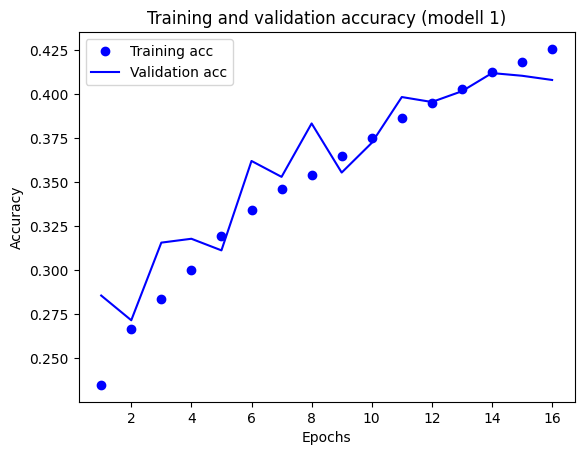

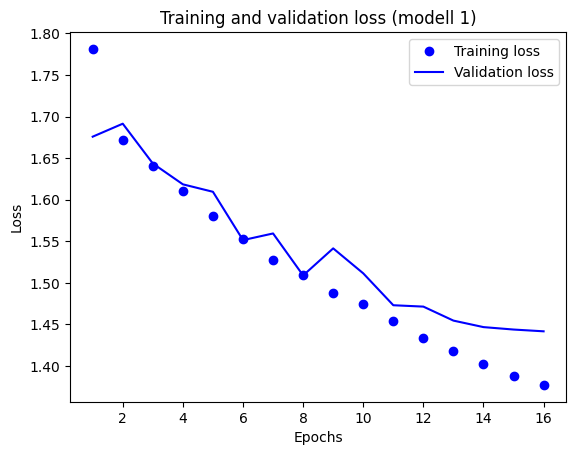

In [24]:
fitModel(sequential_model, x_train, y_train, 16, True, dist_class_weight, 1, 32)